# Small Language Models

Dieses Notebook untersucht mehrere neuronale Netzwerkarchitekturen für Sprachmodellierungsaufgaben. Die Modelle werden anhand einer künstlich generierten Sprache trainiert. Die Aufgabe bleibt dabei dieselbe: die Wahrscheinlichkeit des nächsten Wortes $Y$ anhand der vorherigen Wörter $X$ in einem Satz vorherzusagen.

$$
P(Y | X) 
$$

## Background and Motivation
Das Trainieren von Sprachmodellen anhand realer Sprachdaten erfordert oft umfangreiche Rechenressourcen, wie sie typischerweise in Rechenzentren zu finden sind. Um die grundlegenden Konzepte der Sprachmodellierung auf eine leichter zugängliche Weise zu erforschen, werden wir eine künstlich konstruierte Sprache verwenden. Dieser Ansatz ermöglicht es uns, die Komplexität zu kontrollieren, die zugrunde liegenden Mechanismen zu verstehen und die Ressourceneffizienz sicherzustellen.

## Ziele
Verstehen, Implementieren und Vergleichen verschiedener neuronaler Netzwerkarchitekturen (RNN, LSTM, Transformer) bei Sprachmodellierungsaufgaben unter Verwendung einer künstlich generierten Sprache.

## Aufgaben

### 1. **Artificial Language Generation for Training**:
Erstellen Sie einen initialen Datensatz an Sätzen unter Verwendung einer einfachen, regelbasierten Grammatik (siehe unten).

### 2. **Tokenization**:
Wandeln Sie diese Sätze in Folgen von ganzen Zahlen um.

### 3. **Model Building**: 
Implementieren Sie mindestens die ersten drei Modelle – ein grundlegendes RNN (erforderlich), ein LSTM (erforderlich), ein 1DCNN (erforderlich) und einen Transformer (optional).

### 4. **Training**:
Trainieren Sie jedes Modell anhand des Datensatzes für künstliche Sprachen und bewerten Sie die Leistung jedes Modells während des Trainings anhand des Validierungssatzes, indem Sie die Lernkurven für jedes Modell anzeigen und miteinander vergleichen.

Sie können den unten angegebenen Starter-Code verwenden, um loszulegen. Sie können den Code nach Belieben ändern. Die Architektur der Modelle können Sie selbst bestimmen, sie kann jedoch einfach sein. Für das RNN könnte sie beispielsweise wie folgt aussehen:

| Layer (type)            | Output Shape      | Param # |
|-------------------------|-------------------|---------|
| embedding_1 (Embedding) | (1, 35, 8)        | 208     |
| simple_rnn (SimpleRNN)  | (1, 50)           | 2,950   |
| dense (Dense)           | (1, 26)           | 1,275   |

Wichtig ist, eine geeignete Verlustfunktion für das nächste vorhergesagte Token zu wählen. Im obigen Beispiel beträgt die Vokabulargröße 25.

## Festlegen des Keras Backends

In [68]:
################# Keras with JAX Backend ################
##### We use the JAX backend for Keras
import jax 
print(jax.__version__)

##### We set the KERAS_BACKEND environment variable to "jax"
import os
os.environ["KERAS_BACKEND"] = "jax"

##### We import Keras
import keras
print(keras.__version__)

0.8.2
3.13.0


## Seltsame Sprache

Wir verwenden das folgende Verfahren, um Beispiele aus der Sprache zu generieren

In [69]:
import random
# Define the grammar rules
expanded_grammar = {
    'S': [['NP', 'VP'], ['S', 'CONJ', 'S']],
    'NP': [['Det', 'ADJ', 'N'], ['Det', 'N'], ['Det', 'N', 'PP']],
    'VP': [['V', 'NP'], ['V', 'NP', 'PP'], ['V', 'ADV']],
    'PP': [['P', 'NP']],
    'Det': ['a', 'the'],
    'N': ['cat', 'dog', 'bird', 'tree'],
    'V': ['sits', 'runs', 'flies', 'jumps'],
    'ADJ': ['big', 'small', 'quick', 'lazy'],
    'ADV': ['quickly', 'slowly', 'carefully'],
    'P': ['on', 'in', 'under', 'over'],
    'CONJ': ['and', 'but', 'or']
}

def generate_sentence(symbol, depth=0, max_depth=5):
    if depth > max_depth:  # Limiting recursion depth
        return ''

    if symbol not in expanded_grammar:
        return symbol

    expansion = random.choice(expanded_grammar[symbol])
    if isinstance(expansion, list):
        return ' '.join([generate_sentence(sym, depth+1, max_depth) for sym in expansion]).strip()
    else:
        return expansion

### Generierung von Trainings- und Testdaten 

Hier generieren wir die Trainings- und Testdaten für die Sprache. 

In [ ]:
import random
import numpy as np
# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generating sentences
num_train = 1000                        # Number of training examples
num_test  = 2000                        # Number of test examples
num_sentences = num_train + num_test    # Number of sentences to generate
sentences = [generate_sentence('S') for _ in range(num_sentences)]

# Sample some sentences
for i in range(5):
    print(f"{i} {sentences[i]}")

max_length = max(len(sentence.split()) for sentence in sentences)

0 the small dog sits a tree on a small cat
1 the dog under a lazy bird runs the big cat on the bird
2 the cat on the bird on runs slowly
3 a lazy bird flies the quick dog on a dog over
4 the cat on the bird runs the dog over but a dog flies carefully


### Tokenisierung

Im Schritt „Tokenisierung” wandeln wir den eingegebenen Text in ganze Zahlen um. 

In [71]:
import numpy as np
import jax.numpy as jnp
from keras.layers import TextVectorization

# Define TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=40, # Maximum vocabulary size (will be less)
    output_mode="int"
)

# Adapt the vectorization layer
vectorize_layer.adapt(sentences)

# Vectorize sentences (output is JAX-compatible)
sequences = vectorize_layer(sentences)
print(sequences[:4])

vocab_size = len(vectorize_layer.get_vocabulary())
print(vocab_size)


# get frequency of each word
#from collections import Counter
#word_counts = Counter()
#for sentence in sentences:
#    word_count

[[ 2 18  7 13  3  4 15  3 18  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  7 16  3 22  5 12  2 20  6 15  2  5  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  6 15  2  5 15 12 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 22  5 14  2 19  7 15  3  7 17  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]]
26


### Padding

Da der eingegebene Text eine variable Länge haben kann, wurde bei der Tokenisierung am Ende des Textes eine 0 hinzugefügt, um alle Texte auf die gleiche Länge zu bringen. Wir möchten jedoch, dass der Text mit einem echten Token endet. Deshalb nehmen wir die 0 am Ende und verschieben sie an den Anfang des Textes.

In [72]:
# Function to shift padding tokens to the beginning
def move_padding_to_front(sequence, padding_value=0):
    non_padding = sequence[sequence != padding_value]
    padding = sequence[sequence == padding_value]
    return jnp.concatenate([padding, non_padding])

# Apply the function to all sequences
adjusted_sequences = jnp.array([move_padding_to_front(seq) for seq in sequences])

# Print adjusted sequences
print(adjusted_sequences[:4])
del(sequences)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  2 18  7 13  3  4 15  3 18  6]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
   7 16  3 22  5 12  2 20  6 15  2  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  2  6 15  2  5 15 12 24]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  3 22  5 14  2 19  7 15  3  7 17]]


### Training and Test Data
Der erste Teil der Sätze wird für Trainingsdaten verwendet, mit dem Ziel, das letzte Token des Satzes vorherzusagen.

In [73]:
# Prepare X and y for training
X = adjusted_sequences[:num_train, :-1]
Y = keras.utils.to_categorical(adjusted_sequences[:num_train, -1], num_classes=vocab_size)

# Prepare X_test and y_test
X_test = adjusted_sequences[num_train:, :-1]
y_test = keras.utils.to_categorical(adjusted_sequences[num_train:, -1], num_classes=vocab_size)

# Changes end here
# The first sentence
print(f"The first sentence :\'{sentences[0]}\'")
print(f"The first sentence after tokenization and padding :\n{adjusted_sequences[0]}")
print(f"The first sentence X for training (note the last token is missing):\n{X[0]}")
print(f"The first sentence Y for training (note that this is one-hot-encoded):\n{Y[0]}") 

print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

The first sentence :'the small dog sits a tree on a small cat'
The first sentence after tokenization and padding :
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18  6]
The first sentence X for training (note the last token is missing):
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  2 18  7 13  3  4 15  3 18]
The first sentence Y for training (note that this is one-hot-encoded):
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Shape of X: (1000, 35)
Shape of Y: (1000, 26)


### Shapes and Embeddings
`X` ist eine spärliche (*sparse*) Darstellung im Code. Anstatt die Token mit One-Hot-Coding zu kodieren, verwenden wir den Token-Index, d. h. jedes Wort/Token entspricht einem ganzzahligen Wert. Dies ist eine effizientere Darstellung der Daten, aber konzeptionell ist es dasselbe.

`Y` ist eine One-Hot-Kodierung mit der Form Batch, Vocabulary. Es handelt sich um das One-Hot-kodierte Ergebnis des nächsten Tokens. Beachten Sie, dass wir hier das **zuletzt vorhergesagte Wort** verwenden. Dies vereinfacht unseren Code, ist jedoch weniger effizient. In technischen Umsetzungen wird auch das Wort für alle $t=1..T$ als Ziel verwendet.

In unserem oben gezeigten Beispiel beträgt die Vokabulargröße 26. In unserem Trainingssatz `X` wurde das zu ermittelnde Wort "cat" entfernt. Dies hatte einen Token von 6. Daher ist `Y` in diesem Fall eine One-Hot-Kodierung mit einer 1 an der 6. Position.

#### Embedding layer
Der erste Schritt, den wir von $X(B,T,V)$ zu $X(B,T,C)$ durchführen, ist die Einbettungsschicht (*Embedding-Layer*). Dabei handelt es sich um eine einfache Matrixmultiplikation. Die Größe der Einbettungsschicht `C` ist ein Hyperparameter. 

In [74]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8  # Embedding dimension (a.k.a. C)
EPOCHS = 50
BATCH_SIZE = 64
# Define the model
emb_model = Sequential()
emb_model.add(Embedding(vocab_size, EMB_DIM)) 
### 
# <---- Add your model here ---->
###

# Predict embeddings for the input data
embeddings = emb_model.predict(X)  # X is already prepared as input sequences
print(f"Shape {embeddings.shape} (Batch, Time, Embedding)")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Shape (1000, 35, 8) (Batch, Time, Embedding)


Ausgehend von der Einbettungsschicht oben können wir nun RNN, LSTM, 1DCNN oder Transformer anwenden.

In [75]:
#### Plotfunktion
import matplotlib.pyplot as plt

def plot_learning_curves(history, title="Learning Curves"):
    """
    history: dict mit Schlüsseln
        'val_accuracy', 'val_loss'
    """
    plt.figure(figsize=(6,4))
    plt.plot(history["val_accuracy"], label="Validation Accuracy")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### RNN

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_36 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

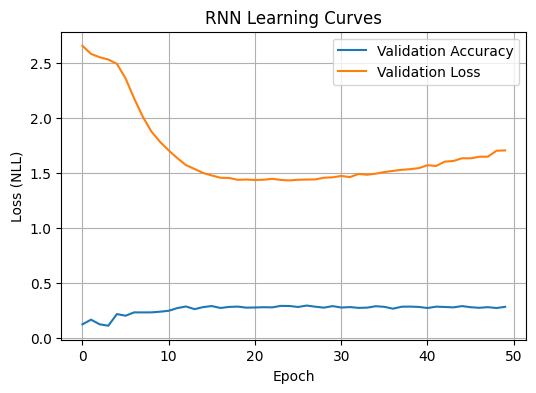

In [76]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

EMB_DIM = 8

def build_rnn_model(vocab_size):
    model = Sequential([
        Embedding(vocab_size, EMB_DIM),
        SimpleRNN(128, return_sequences=False),
        Dense(vocab_size, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

rnn_model = build_rnn_model(vocab_size)
rnn_model.summary()

history = rnn_model.fit(
    X, Y,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=0
)

plot_learning_curves(history.history, title="RNN Learning Curves")

### LSTM

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_34 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

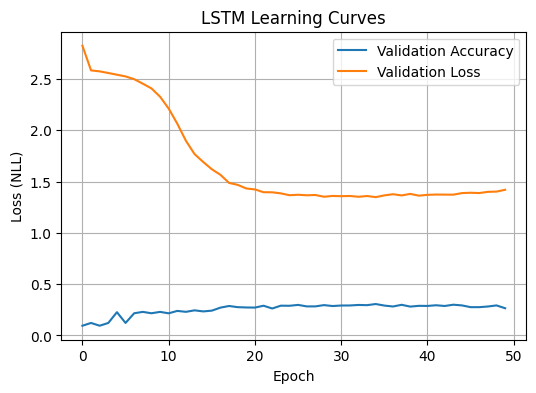

In [77]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

EMB_DIM = 8

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, EMB_DIM))

# LSTM statt SimpleRNN
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dense(vocab_size, activation="softmax"))

lstm_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # passt zu One-Hot-Y
    metrics=["accuracy"]
)

lstm_model.summary()

history_lstm = lstm_model.fit(
    X,        # (B, T)
    Y,        # (B, Vocabulary)
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=0
)

plot_learning_curves(history_lstm.history, title="LSTM Learning Curves")

### 1DCNN

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_39 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

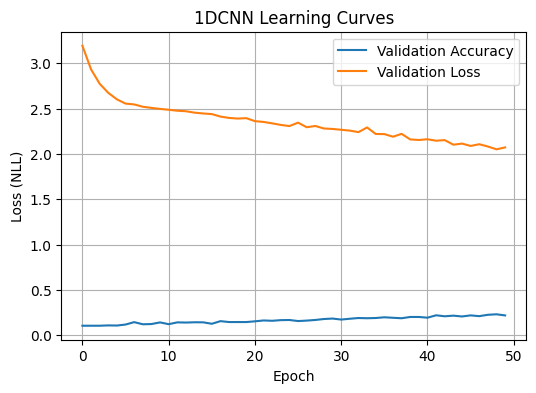

In [85]:
from keras.models import Sequential
from keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense
)

EMB_DIM = 8

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, EMB_DIM))

cnn_model.add(Conv1D(vocab_size, 3, activation='relu', padding='causal', dilation_rate=1))
cnn_model.add(Conv1D(vocab_size, 3, activation='relu', padding='causal', dilation_rate=2))
cnn_model.add(Conv1D(vocab_size, 3, activation='relu', padding='causal', dilation_rate=4))
cnn_model.add(Conv1D(vocab_size, 3, activation='relu', padding='causal', dilation_rate=8))

# Aggregation über die Zeitachse
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(vocab_size, activation="softmax"))

cnn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

history_cnn = cnn_model.fit(
    X,
    Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=0
)

plot_learning_curves(history_cnn.history, title="1DCNN Learning Curves")

### Vergleich der Modelle

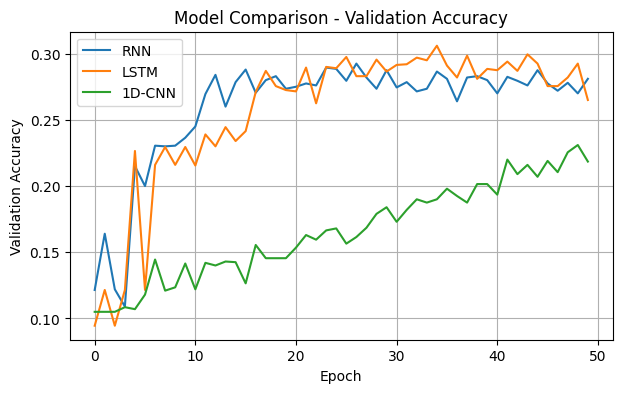

In [86]:
plt.figure(figsize=(7,4))
plt.plot(history.history["val_accuracy"], label="RNN")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM")
plt.plot(history_cnn.history["val_accuracy"], label="1D-CNN")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison - Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Transformer